### Dataset Link:
- https://www.kaggle.com/c/data-science-bowl-2018/data

### Setup:

In [52]:
# from google.colab import drive
# drive.mount('/content/drive')

# !mkdir test
# %cd test
# !unzip "/content/drive/My Drive/stage1_test.zip"

# %cd ..
# !mkdir train
# %cd train
# !unzip "/content/drive/My Drive/stage1_train.zip"
# %cd ..

In [2]:
!ls

drive  sample_data  test  train


In [58]:
import tensorflow as tf
import os
import random
import numpy as np
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import skimage.measure

## Setting up the Data:

In [4]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH = 'train/'
TEST_PATH = 'test/'

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [5]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [7]:
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')

100%|██████████| 670/670 [00:05<00:00, 132.44it/s]


In [8]:
start = timer()

print('\nResizing training images and masks\n')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
            
    Y_train[n] = mask   

  0%|          | 0/670 [00:00<?, ?it/s]


Resizing training images and masks



100%|██████████| 670/670 [07:55<00:00,  1.41it/s]


In [9]:
# test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

In [10]:
sizes_test = []
print('\nResizing test images\n') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('\nDone!\n')
end = timer()
print("\nTime taken load data: ", end - start, "seconds\n") 

  6%|▌         | 4/65 [00:00<00:01, 39.30it/s]


Resizing test images



100%|██████████| 65/65 [00:02<00:00, 27.41it/s]



Done!


Time taken load data:  477.85138819699995 seconds



In [11]:
X_train = tf.random.shuffle(X_train, seed=101).numpy()
Y_train = tf.random.shuffle(Y_train, seed=101).numpy()
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)

(670, 128, 128, 3)
(670, 128, 128, 1)
(65, 128, 128, 3)


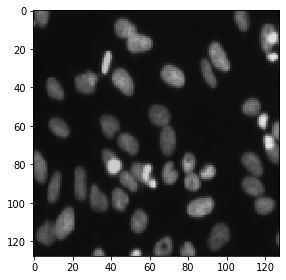

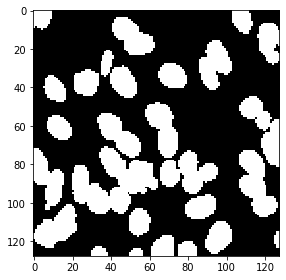

In [12]:
# display random x_train and y_train image:
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

In [24]:
# FCN8 Model

def fcn8(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, kernel_size):
  inputs = tf.keras.layers.Input(shape=(None, None, IMG_CHANNELS))
  s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs) # converting to float so keras can handle it better

  # Downsampling
  c1 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(s)
  # c1 = tf.keras.layers.Dropout(0.1)(c1)
  c1 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(c1)
  p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

  c2 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(p1)
  # c2 = tf.keras.layers.Dropout(0.1)(c2)
  c2 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c2)
  p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

  c3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p2)
  c3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c3)
  # c3 = tf.keras.layers.Dropout(0.2)(c3)
  c3 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c3)
  p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

  c4 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p3)
  c4 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
  # c4 = tf.keras.layers.Dropout(0.2)(c4)
  c4 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)
  p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

  c5 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p4)
  c5 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)
  # c5 = tf.keras.layers.Dropout(0.3)(c5)
  c5 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)
  p5 = tf.keras.layers.MaxPooling2D((2, 2))(c5)

  c6 = tf.keras.layers.Conv2D(512, (7, 7), activation='relu', padding='same')(p5)
  # c6 = tf.keras.layers.Dropout(0.5)(c6)
  c6 = tf.keras.layers.Conv2D(512, (1, 1), activation='relu', padding='same')(c6)
  c6 = tf.keras.layers.Dropout(0.5)(c6)

  # Upsampling
  # deconv 1
  u1 = tf.keras.layers.Conv2DTranspose(1, kernel_size=kernel_size, strides=(2, 2), padding='same')(c6)

  p4_n = tf.keras.layers.Conv2D(1, (2, 2), activation='relu', padding='same')(p4)

  # deconv 2
  u2 = tf.keras.layers.Add()([u1, p4_n])
  u2 = tf.keras.layers.Conv2DTranspose(1, kernel_size=kernel_size, strides=(2, 2), padding='same')(u2)

  p3_n = tf.keras.layers.Conv2D(1, (2, 2), activation='relu', padding='same')(p3)

  
  #deconv 3
  u3 = tf.keras.layers.Add()([u2, p3_n])

  # multiply top kernel size by 4:
  outputs = tf.keras.layers.Conv2DTranspose(1, kernel_size=kernel_size*4, strides=(8, 8), padding='same', activation='sigmoid')(u3)

  model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  model.summary()

  return model


In [25]:
kernel_size = 8

model = fcn8(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, kernel_size)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, None, None, 8 224         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, None, None, 8 584         conv2d_17[0][0]                  
_______________________________________________________________________________________

In [26]:
#Modelcheckpoint
# checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei_3.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
        # tf.keras.callbacks.EarlyStopping(patience=5, monitor='accuracy'),
        # tf.keras.callbacks.TensorBoard(log_dir='logs', histogram_freq=1)
]

start = timer()

results = model.fit(X_train, Y_train, validation_split=0.2, batch_size=32, epochs=200, callbacks=callbacks)
# results = model.fit(X_train[:100], Y_train[:100], epochs=250, callbacks=callbacks)

end = timer()
print("\nTime taken for Model to Run: ", end - start, "seconds\n") 

Epoch 1/200
17/17 [==============================] - 22s 1s/step - loss: 0.6637 - accuracy: 0.7002 - val_loss: 0.6001 - val_accuracy: 0.7844
Epoch 2/200
17/17 [==============================] - 21s 1s/step - loss: 0.5513 - accuracy: 0.7873 - val_loss: 0.5003 - val_accuracy: 0.8103
Epoch 3/200
17/17 [==============================] - 21s 1s/step - loss: 0.5179 - accuracy: 0.7965 - val_loss: 0.4915 - val_accuracy: 0.8108
Epoch 4/200
17/17 [==============================] - 22s 1s/step - loss: 0.5148 - accuracy: 0.7967 - val_loss: 0.4875 - val_accuracy: 0.8108
Epoch 5/200
17/17 [==============================] - 21s 1s/step - loss: 0.5064 - accuracy: 0.7967 - val_loss: 0.4799 - val_accuracy: 0.8108
Epoch 6/200
17/17 [==============================] - 21s 1s/step - loss: 0.4963 - accuracy: 0.7967 - val_loss: 0.4645 - val_accuracy: 0.8108
Epoch 7/200
17/17 [==============================] - 21s 1s/step - loss: 0.4792 - accuracy: 0.7966 - val_loss: 0.4348 - val_accuracy: 0.8109
Epoch 8/200
1

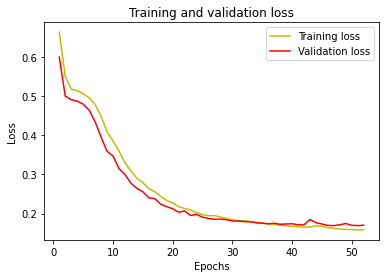

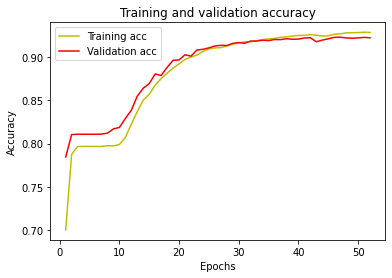

In [27]:
#plot the training and validation accuracy and loss at each epoch
loss = results.history['loss']
val_loss = results.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = results.history['accuracy']
val_acc = results.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [49]:
preds_train = model.predict(X_train, verbose=1)
preds_test = model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

3/3 [==============================] - 0s 113ms/step


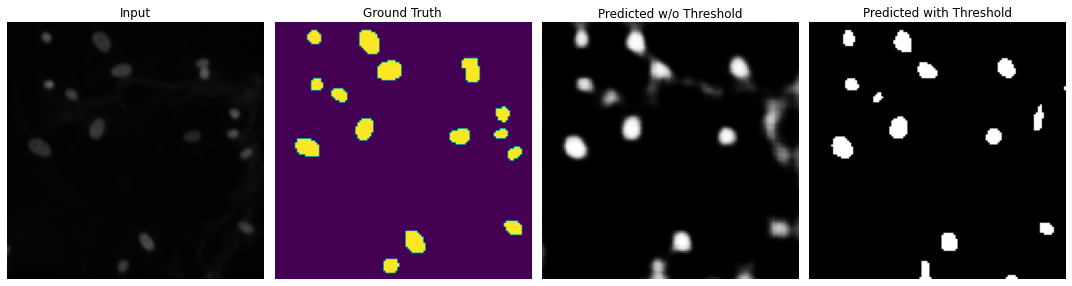

In [50]:
# Perform predictions on some training samples
ix = random.randint(0, len(preds_train_t))

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,10))

ax[0].set_title("Input")
ax[0].imshow(X_train[ix])

ax[1].set_title("Ground Truth")
ax[1].imshow(np.squeeze(Y_train[ix]))

ax[2].set_title("Predicted w/o Threshold")
ax[2].imshow(np.squeeze(preds_train[ix]), cmap='gray')

ax[3].set_title("Predicted with Threshold")
ax[3].imshow(np.squeeze(preds_train_t[ix]), cmap='gray')

for a in ax:
  a.axis("off")

plt.tight_layout()
plt.show()


In [59]:
# function to calculate Intersection Over Union (IOU) score:
def iou_score(truth, predicted):
    intersection = np.logical_and(truth, predicted)
    union = np.logical_or(truth, predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    
    return iou_score

iou = iou_score(Y_train, preds_train_t)
print("IOU score: ", round(iou, 2))

IOU score:  0.68


In [57]:
# utilize connected component analysis (CCA) to count cells in random (ix) image:
labeled_image = skimage.measure.label(preds_train_t[ix], connectivity=2, return_num=True)

print("mask w/ threshold cell count: ", np.max(labeled_image[0]))

mask w/ threshold cell count:  15


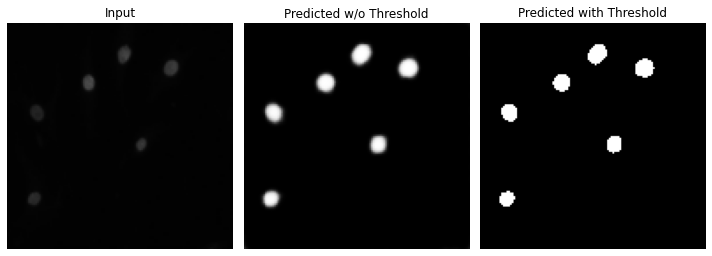

In [60]:
# Perform predictions on some testing samples
ix = random.randint(0, len(preds_test_t))

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,10))

ax[0].set_title("Input")
ax[0].imshow(X_test[ix])

ax[1].set_title("Predicted w/o Threshold")
ax[1].imshow(np.squeeze(preds_test[ix]), cmap='gray')

ax[2].set_title("Predicted with Threshold")
ax[2].imshow(np.squeeze(preds_test_t[ix]), cmap='gray')

for a in ax:
  a.axis("off")

plt.tight_layout()
plt.show()


In [31]:
# %load_ext tensorboard
# %tensorboard --logdir logs

In [47]:
# !rm -r logs

In [33]:
# save model
# model.save('fcn_model_92.h5')

# checkpoint_filepath = 'nuclei_model_3.h5'
# model.load_weights(checkpoint_filepath)

In [34]:
# tf.keras.utils.plot_model(
#     model, to_file='model.png', show_shapes=False, show_layer_names=True,
#     rankdir='TB', expand_nested=False, dpi=96
# )